In [2]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import altair as alt
import igraph
alt.renderers.enable('mimetype')
pm.__version__

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


'5.0.2'

# Dyad sharing model

## Setting up data

First, let's get the data. We have a dataframe with household attributes `kl_households` (25 entries) and a dataframe with their relationships `kl_dyads` (300 entries).

In [3]:
kl_households = pd.read_csv("../../../datasets/kl_households.csv")
kl_dyads = pd.read_csv("../../../datasets/kl_dyads.csv")

In [4]:
kl_dyads.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


In [17]:
kl_households.head()

,hid,hgame,hfish,hpigs,hwealth,hpastor
0,1,0.05,0.06,0.00,14.162,0
1,2,0.25,0.17,1.75,27.405,0
2,3,2.29,0.66,5.75,9.900,0
3,4,0.04,0.43,1.50,7.267,0
4,5,0.07,0.12,1.25,9.982,0


As this session involves quite complex multi-dimensional models, using pyMC's dimension and coordinate support will help a lot. Let's set them up in advance.

In [18]:
#get giver IDs and unique list of givers
giver_idx = kl_dyads['hidA'].values
givers = list(set(giver_idx))

#get giver IDs and unique list of givers
receiver_idx = kl_dyads['hidB'].values
receivers = list(set(receiver_idx))

#make a list of unique households
households = np.array(list(set(givers).union(set(receivers))))

#get a dimension for observations in kl_dyads
index = kl_dyads.index.values

#pull out outcome variables
giver_gifts = kl_dyads['giftsAB'].values
receiver_gifts = kl_dyads['giftsBA'].values

Now, let's set up coordinates:
 - index: helper dimension simply representing number of observations
 - households: 25-long dimension representing households
 - pair: helper dimension for multivariate variables that represent the pair of giver and receiver

In [ ]:
coords = {    
    "pair": ['giver', 'receiver'],
    'index': index,
    "households": households
}

## Basic model

Let's start with the basic model that has only a general giving rate and unobserved ties between households.

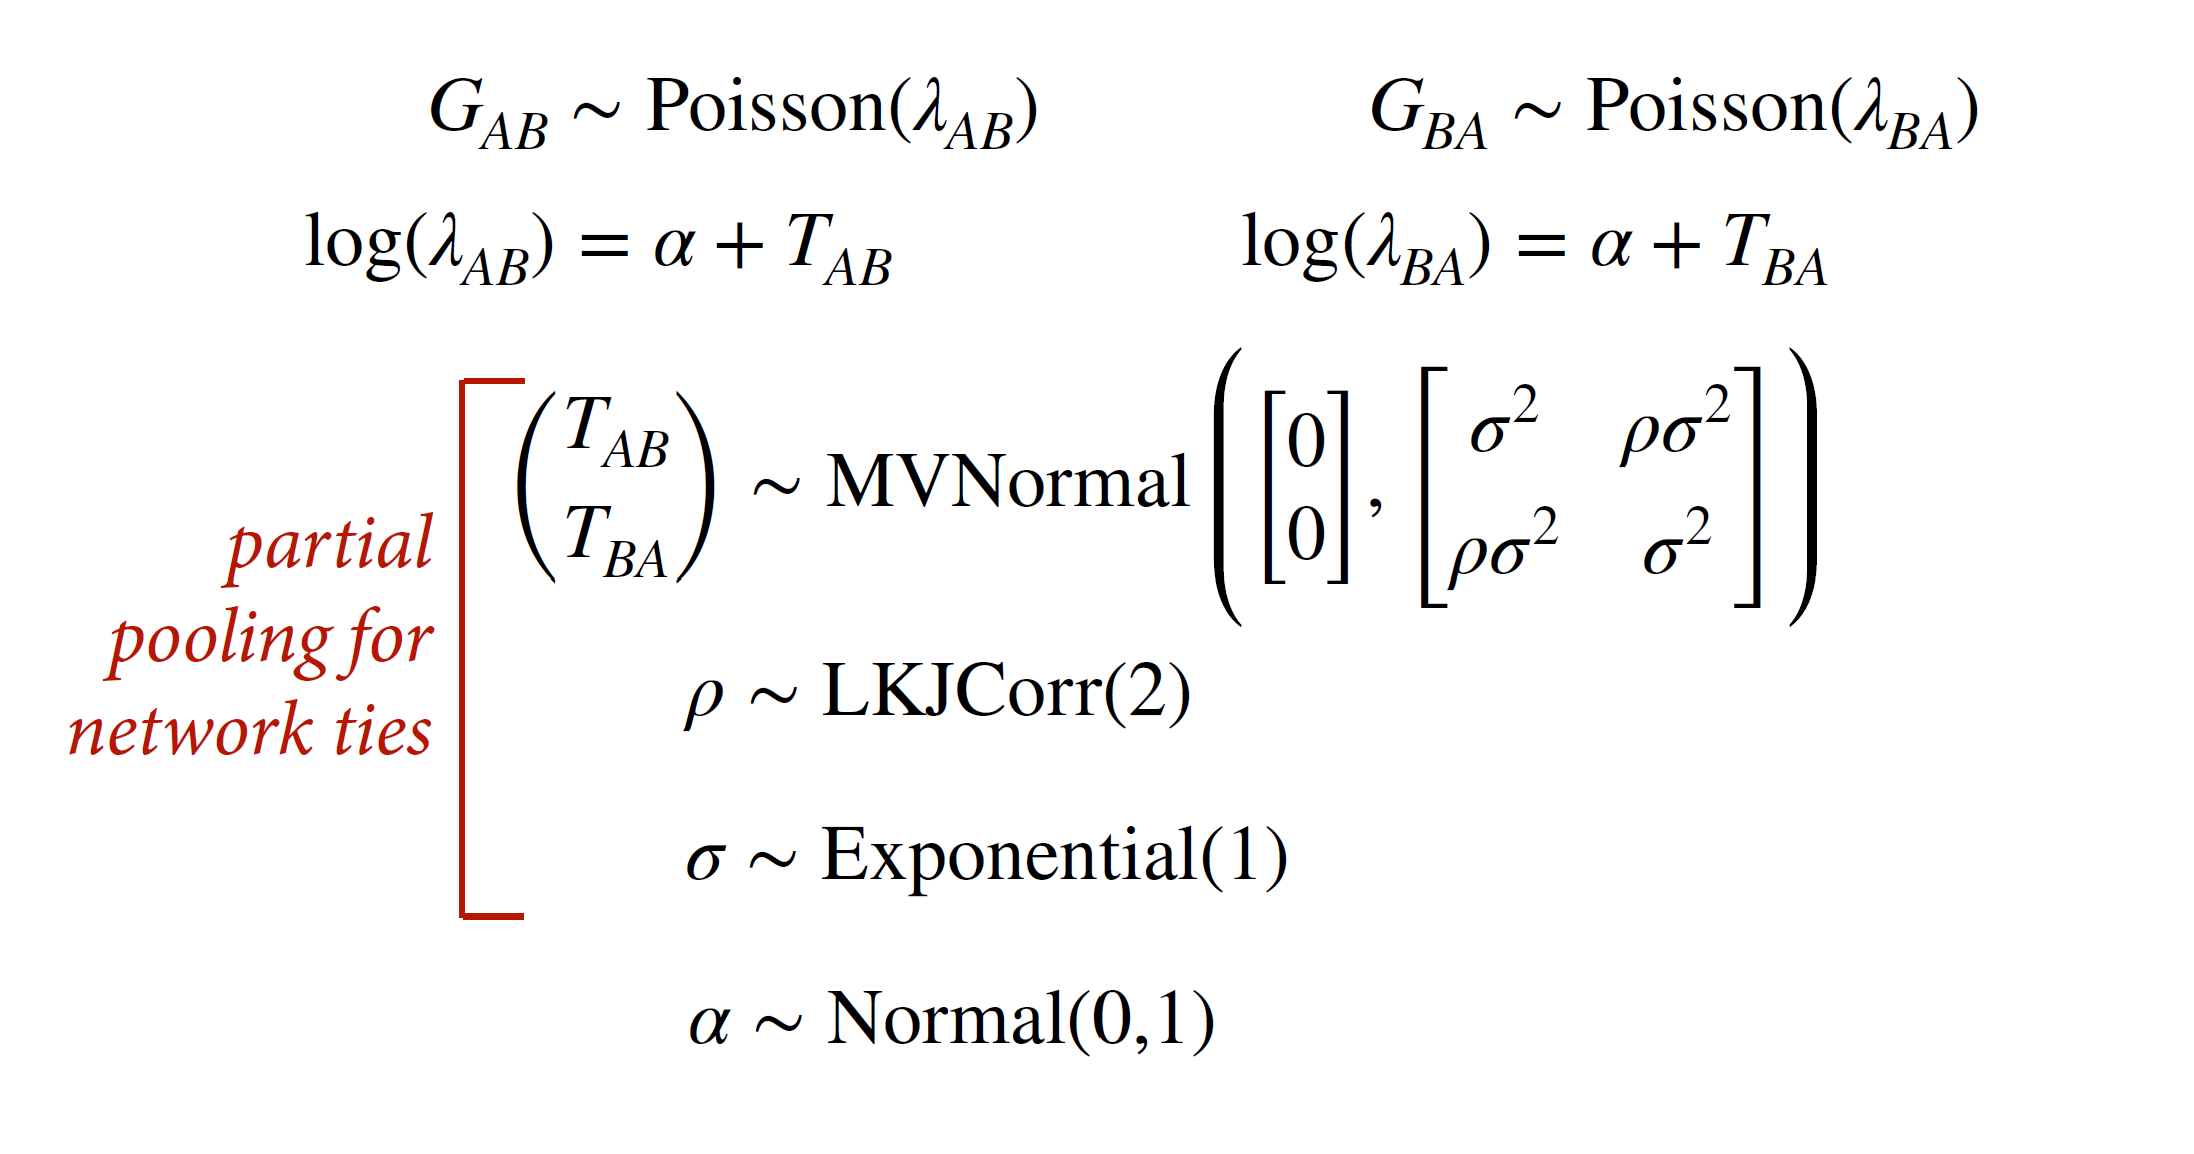

Because we will build models incrementally, I will use some helper functions to minimize code repetition. Basically, all the code beyond the last step will be wrapped in a helper function, so we can reuse it as a building block later.

In [24]:
def create_base_model(data, RVs):
    #setup data    
    data['g_counts'] = pm.MutableData("giver_gifts", giver_gifts, dims='index')
    data['r_counts'] = pm.MutableData("receiver_gifts", receiver_gifts, dims='index')

    #basic giving rate
    RVs['α'] = pm.Normal("α, general giving rate", 0, 1)

    #tie effects (unobservable)
    # this is not identical to lecture - can't force a single variance to be used without getting deeper in internals
    σ = pm.Exponential.dist(1.0)    
    Z = pm.Normal('Z', mu=0, sigma=1, dims=["pair", "index"])
    chol, corr, stds = pm.LKJCholeskyCov('dyad_ties', n=len(coords['pair']), eta=2, sd_dist=σ, compute_corr=True)
    vals = pm.math.dot(chol, Z)
    RVs['T_AB'] = pm.Deterministic("T_AB, tie A to B", vals[0, :], dims="index")
    RVs['T_BA'] = pm.Deterministic("T_BA, tie B to A", vals[1, :], dims="index")

In [25]:
with pm.Model(coords=coords) as base_model:
    data = {}
    RVs = {}
    create_base_model(data, RVs)
    #set up expected rates        
    λ_AB = pm.math.exp(RVs['α'] + RVs['T_AB'][index])
    λ_BA = pm.math.exp(RVs['α'] + RVs['T_BA'][index])

    #set up likelihoods
    pm.Poisson("gifts_given", mu=λ_AB, observed = data['g_counts'], dims='index')
    pm.Poisson("gifts_received", mu=λ_BA, observed = data['r_counts'], dims='index')

Let's visualize the model.

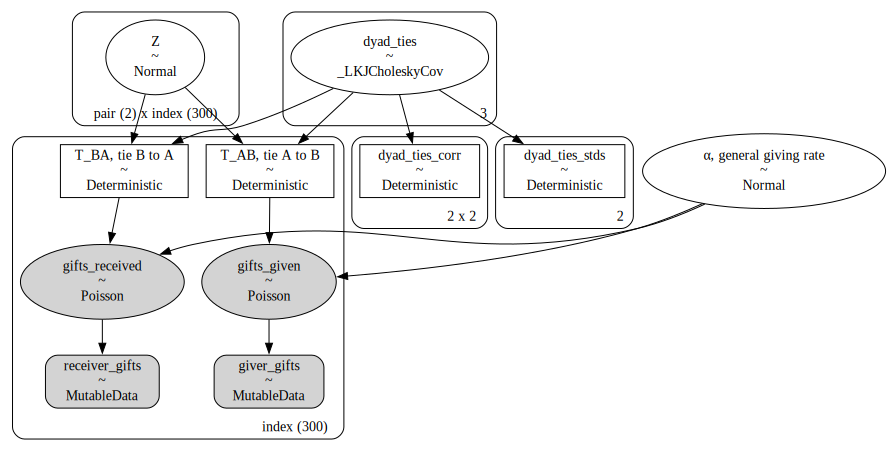

In [26]:
pm.model_to_graphviz(base_model)

And sample!

In [27]:
with base_model:
    base_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:02.267247
Sampling...
Sampling time =  0:00:04.970318
Transforming variables...
Transformation time =  0:00:01.730894


Let's inspect the results. We get the very similar results as in the lecture - a generalized giving rate of ~`.541` and evidence of some ties - the correlation parameter has a posterior with HDI between `0.226` and `0.483`.

array([[<Axes: title={'center': 'dyad_ties_corr'}>,
        <Axes: title={'center': 'dyad_ties_corr'}>]], dtype=object)

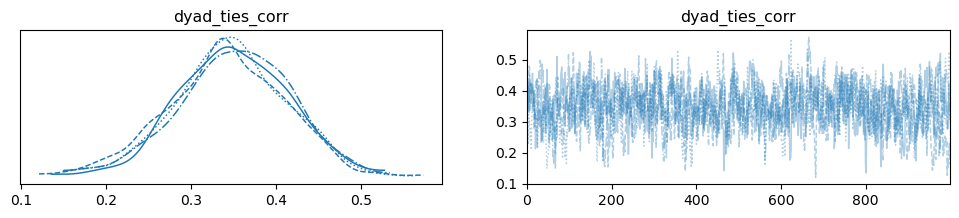

In [30]:
az.plot_trace(
    base_trace, 
    var_names=['dyad_ties_corr'],
    coords={"dyad_ties_corr_dim_0": [1], "dyad_ties_corr_dim_1": [0]}
)

In [76]:
az.summary(
    base_trace, 
    var_names=['dyad_ties_corr', 'dyad_ties_stds', 'α, general giving rate'],
    coords={"dyad_ties_corr_dim_0": [1], "dyad_ties_corr_dim_1": [0]})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"dyad_ties_corr[1, 0]",0.360,0.069,0.226,0.483,0.003,0.002,521.0,852.0,1.01
dyad_ties_stds[0],1.397,0.084,1.243,1.557,0.004,0.003,445.0,1295.0,1.01
dyad_ties_stds[1],1.499,0.087,1.341,1.671,0.004,0.003,514.0,778.0,1.01
"α, general giving rate",0.541,0.082,0.387,0.694,0.003,0.002,998.0,1813.0,1.00


## Adding effects of general household traits

Next, we add the general household giving/receiving traits.
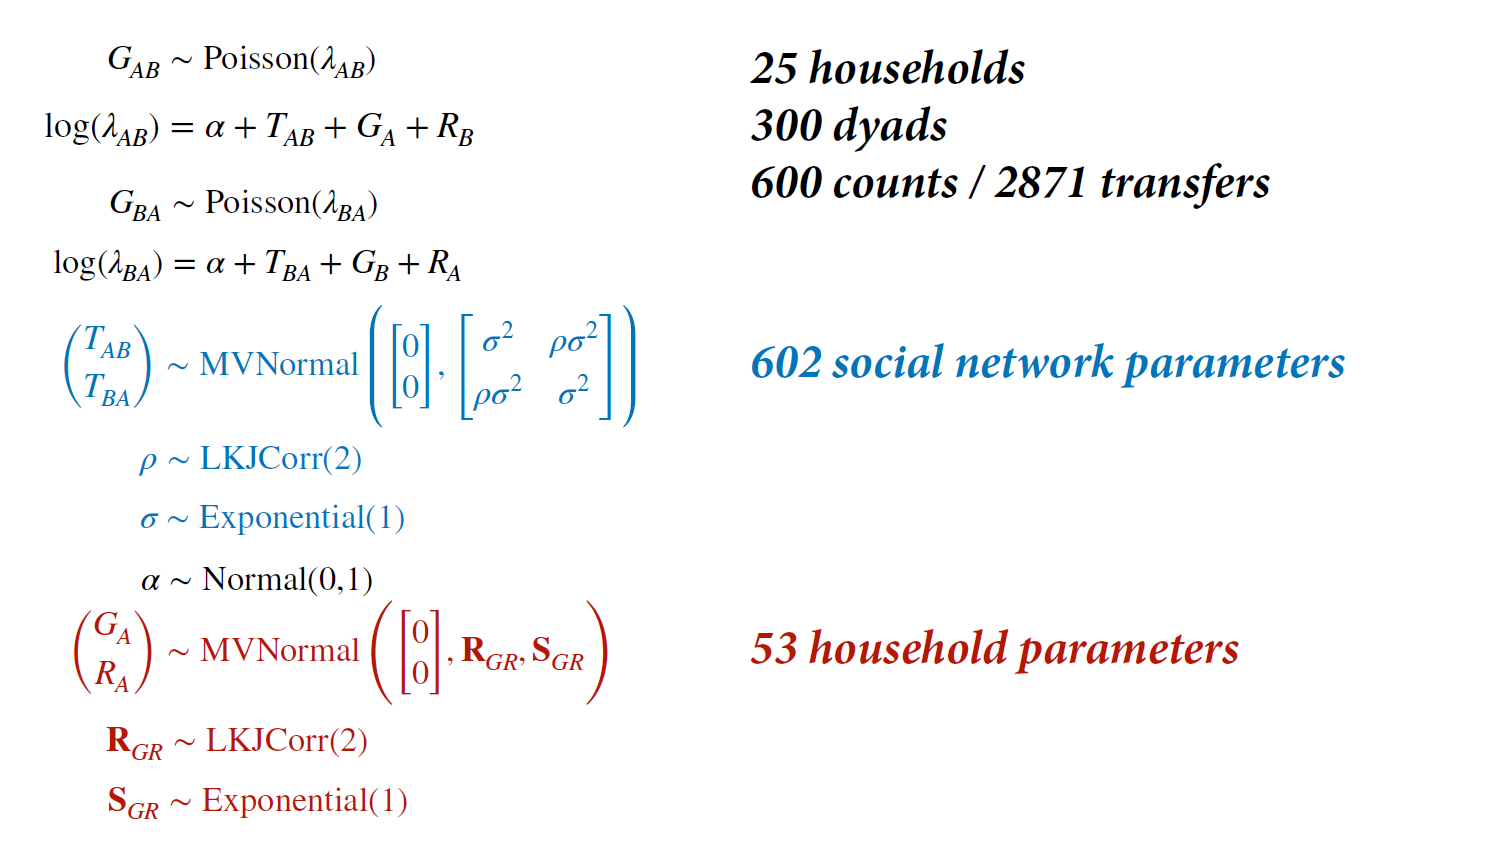

Again, some reusable functions first.

In [31]:
def add_household_traits(data, RVs):
    #add more data
    data['g_id'] = pm.MutableData("giver_ids", giver_idx, coords="givers", dims='index')
    data['r_id'] = pm.MutableData("receiver_ids", receiver_idx, coords="receivers", dims='index')

    #household giving & receiving effects           
    Z_h = pm.Normal('Z_households', mu=0, sigma=1, dims=["pair", "households"])
    chol_h, corr_h, stds_h = pm.LKJCholeskyCov(
        'household_effects', 
        n=len(coords['pair']), 
        eta=2, 
        sd_dist=pm.Exponential.dist(1.0), 
        compute_corr=True
    )
    vals_h = pm.math.dot(chol_h, Z_h)
    RVs['G'] = pm.Deterministic("G, household giving effect", vals_h[0, :], dims="households")
    RVs['R'] = pm.Deterministic("R, household receiving effect", vals_h[1, :], dims="households")    


And then - the composed model. Here, the modularization starts to be useful!

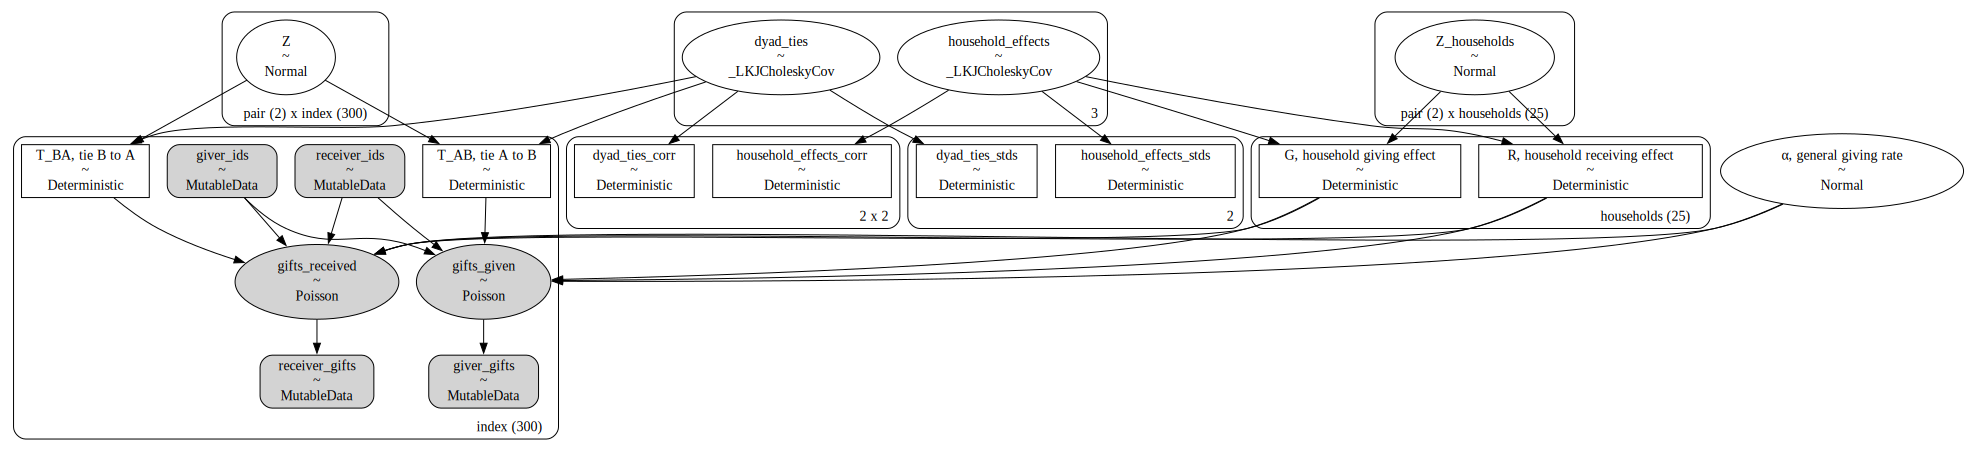

In [32]:
with pm.Model(coords=coords) as household_model:
    data = {}
    RVs = {}
    create_base_model(data, RVs)
    add_household_traits(data, RVs)

    #set up expected rates        
    λ_AB = pm.math.exp(RVs['α'] + RVs['T_AB'][index] + RVs['G'][data['g_id']] + RVs['R'][data['r_id']])
    λ_BA = pm.math.exp(RVs['α'] + RVs['T_BA'][index] + RVs['G'][data['r_id']] + RVs['R'][data['g_id']])

    #set up likelihoods
    pm.Poisson("gifts_given", mu=λ_AB, observed = data['g_counts'], dims='index')
    pm.Poisson("gifts_received", mu=λ_BA, observed = data['r_counts'], dims='index')
    
pm.model_to_graphviz(household_model)

Let's sample and inspect the results.

In [33]:
with household_model:
    household_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:04.996596
Sampling...
Sampling time =  0:00:08.899589
Transforming variables...
Transformation time =  0:00:05.223463


In [34]:
az.summary(
    household_trace, 
    var_names=[
        'dyad_ties_corr', 'dyad_ties_stds', 
        'α, general giving rate', 
        'household_effects_corr', 'household_effects_stds', 
    ],
    coords={
        "dyad_ties_corr_dim_0": [1], "dyad_ties_corr_dim_1": [0], 
        'household_effects_corr_dim_0': [1], 'household_effects_corr_dim_1': [0]
    })

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"dyad_ties_corr[1, 0]",0.940,0.026,0.894,0.985,0.001,0.001,860.0,1345.0,1.0
dyad_ties_stds[0],1.089,0.067,0.963,1.214,0.002,0.001,1240.0,2258.0,1.0
dyad_ties_stds[1],1.151,0.067,1.031,1.275,0.002,0.001,1398.0,2304.0,1.0
"α, general giving rate",0.543,0.161,0.239,0.852,0.005,0.004,1044.0,1640.0,1.0
"household_effects_corr[1, 0]",-0.520,0.211,-0.874,-0.105,0.007,0.005,879.0,1121.0,1.0
household_effects_stds[0],0.827,0.140,0.571,1.080,0.004,0.003,1333.0,1870.0,1.0
household_effects_stds[1],0.409,0.093,0.246,0.587,0.003,0.002,1033.0,1746.0,1.0


Again - all looks good.

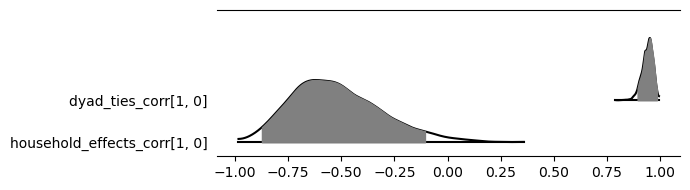

In [43]:
az.plot_forest(
    household_trace, 
    var_names=[
        'dyad_ties_corr',         
        'household_effects_corr', 
    ],
    coords={
        "dyad_ties_corr_dim_0": [1], "dyad_ties_corr_dim_1": [0], 
        'household_effects_corr_dim_0': [1], 'household_effects_corr_dim_1': [0]
    }, 
    combined=True,
    kind='ridgeplot',
    ridgeplot_truncate=False,
    colors="gray",
    figsize=(7,2)
)

plt.tight_layout()
plt.show()

Let's try to replicate the social network illustration, too. It looks "similar" - but hard to tell without labels.

In [44]:
#form adjacency matrix
A = np.zeros((len(households), len(households)))
A[giver_idx, receiver_idx] = household_trace['posterior']['T_AB, tie A to B'].mean(dim=['chain', 'draw'])
A[receiver_idx, giver_idx] = household_trace['posterior']['T_BA, tie B to A'].mean(dim=['chain', 'draw'])
np.fill_diagonal(A, 0)

In [53]:
A_pruned = A.copy()
A_pruned[A_pruned < 1] = 0
A_pruned = A_pruned / A_pruned.max()

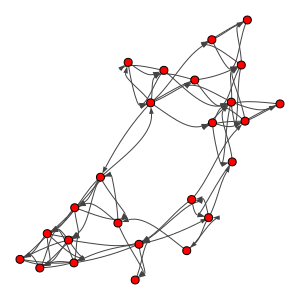

In [56]:
GG = igraph.Graph.Weighted_Adjacency(A_pruned)

igraph.plot(GG, 
    layout="fr",         
    vertex_size=8 ,
    edge_arrow_size=0.5 , 
    edge_curved=0.1, asp=0.1, 
    bbox=(300, 300), margin=20
)

## Model with external variables about households

Final model - let's add external information about actual relationships between households and their wealth.

In [58]:
def add_external_vars(data, RVs):
    #add more data
    standard_assoc = (kl_dyads['dass'] - kl_dyads['dass'].mean()) / kl_dyads['dass'].std()
    standard_wealth = (kl_households['hwealth'] - kl_households['hwealth'].mean()) / kl_households['hwealth'].std()
    data['associations'] = pm.MutableData("associations_data", standard_assoc.values, dims='index')
    data['wealth'] = pm.MutableData("wealth_data", standard_wealth.values, coords='households', dims='households')

    #add two more variables
    RVs['W'] = pm.Normal("wealth", dims="pair")
    RVs['A'] = pm.Normal("association")

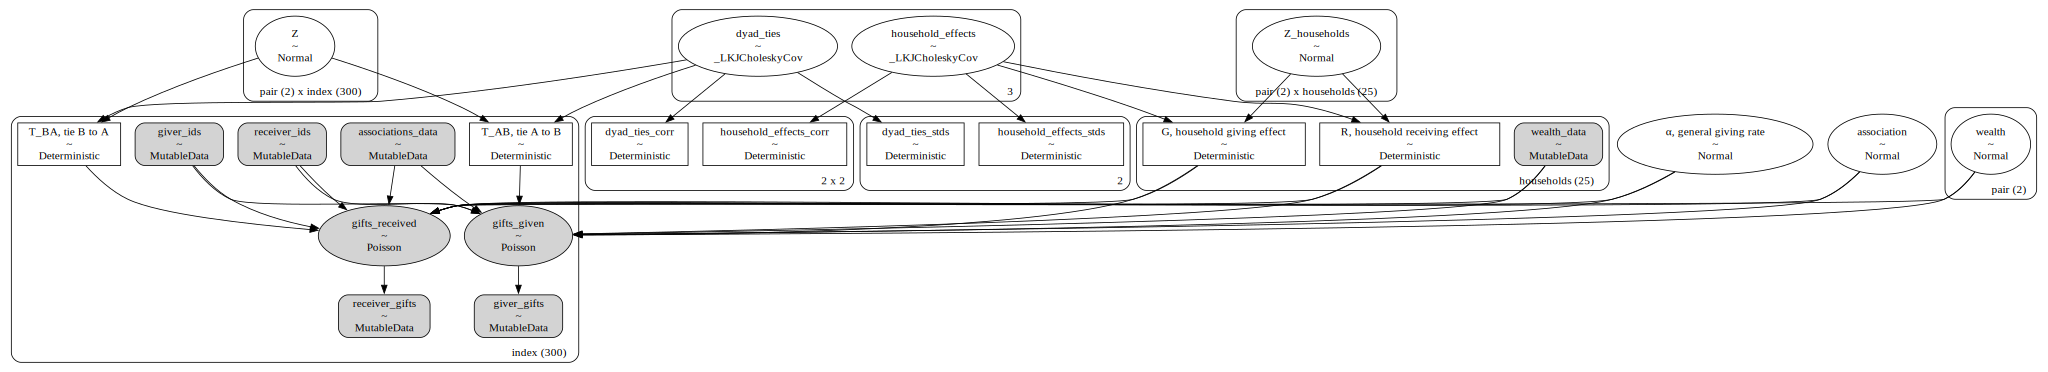

In [67]:
with pm.Model(coords=coords) as final_model:
    data = {}
    RVs = {}

    create_base_model(data, RVs)
    add_household_traits(data, RVs)
    add_external_vars(data, RVs)

    full_T_AB = RVs['T_AB'][index] + RVs['A']*data['associations']
    full_T_BA = RVs['T_BA'][index] + RVs['A']*data['associations']

    full_G_AB = RVs['G'][data['g_id']] + RVs['W'][0]*data['wealth'][data['g_id']]
    full_R_AB = RVs['R'][data['r_id']] + RVs['W'][1]*data['wealth'][data['r_id']]

    full_G_BA = RVs['G'][data['r_id']] + RVs['W'][0]*data['wealth'][data['r_id']]
    full_R_BA = RVs['R'][data['g_id']] + RVs['W'][1]*data['wealth'][data['g_id']]

    #set up expected rates        
    λ_AB = pm.math.exp(RVs['α'] + full_T_AB + full_G_AB + full_R_AB)
    λ_BA = pm.math.exp(RVs['α'] + full_T_BA + full_G_BA + full_R_BA)

    #set up likelihoods
    pm.Poisson("gifts_given", mu=λ_AB, observed = data['g_counts'], dims='index')
    pm.Poisson("gifts_received", mu=λ_BA, observed = data['r_counts'], dims='index')
    
pm.model_to_graphviz(final_model)

In [63]:
with final_model:
    final_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:03.705704
Sampling...
Sampling time =  0:00:09.179157
Transforming variables...
Transformation time =  0:00:04.782869


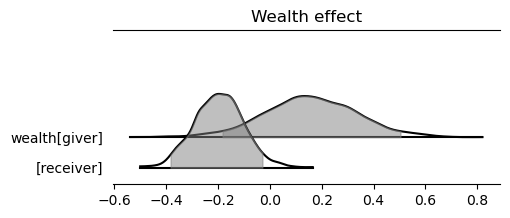

In [85]:
ax = az.plot_forest(
    final_trace, 
    var_names=['wealth'],
    combined=True,
    figsize=(5,2),
    kind='ridgeplot',
    colors='grey',
    ridgeplot_truncate=False,
    ridgeplot_overlap=2,
    ridgeplot_alpha=0.5
)
ax[0].set_title("Wealth effect")
plt.show()

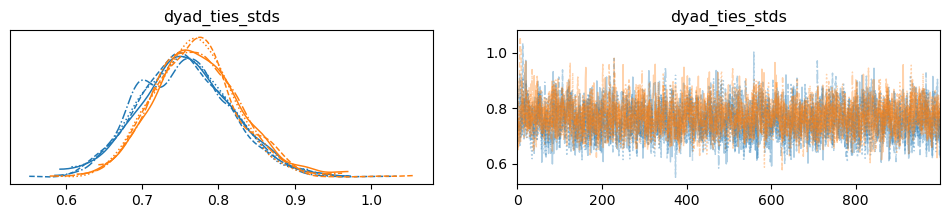

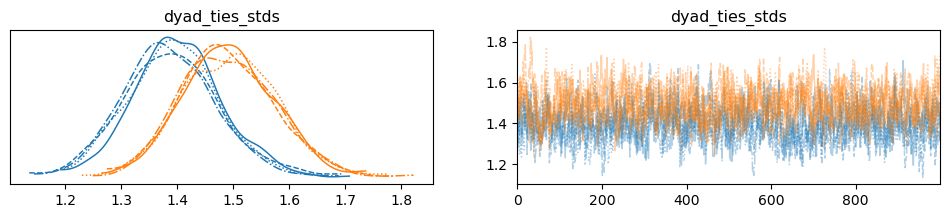

In [86]:
az.plot_trace(
    final_trace, 
    var_names=['dyad_ties_stds',],
    coords={"dyad_ties_corr_dim_0": [1], "dyad_ties_corr_dim_1": [0]}
)
plt.show()

az.plot_trace(
    base_trace, 
    var_names=['dyad_ties_stds',],
    coords={"dyad_ties_corr_dim_0": [1], "dyad_ties_corr_dim_1": [0]},    
)
plt.show()